In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

from jax import vmap
import jax.numpy as np
import jax.random as random
from jax.nn import elu, relu

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

%matplotlib inline

In [2]:

def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(onp.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + onp.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + onp.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
# a two-layer bayesian neural network with computational flow
# given by D_X => D_H => D_H => D_Y where D_H is the number of
# hidden units. (note we indicate tensor dimensions in the comments)
def model(X, Y, D_H):

    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(np.zeros((D_X, D_H)), np.ones((D_X, D_H))))  # D_X D_H
    z1 = elu(np.matmul(X, w1))   # N D_H  <= first layer of activations

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(np.zeros((D_H, D_H)), np.ones((D_H, D_H))))  # D_H D_H
    z2 = elu(np.matmul(z1, w2))  # N D_H  <= second layer of activations

    w3 = numpyro.sample("w3", dist.Normal(np.zeros((D_H,D_H)), np.ones((D_H,D_H))))
    z3 = elu(np.matmul(z2, w3))

    # sample final layer of weights and neural network output
    w4 = numpyro.sample("w4", dist.Normal(np.zeros((D_H, D_Y)), np.ones((D_H, D_Y))))  # D_H D_Y
    z4 = np.matmul(z3, w4)  # N D_Y  <= output of the neural network

    # we put a prior on the observation noise
    #prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    #sigma_obs = 1.0 / np.sqrt(prec_obs)

    # observe data
    #numpyro.sample("Y", dist.Normal(z3, sigma_obs), obs=Y)
    numpyro.sample("Y", dist.Bernoulli(logits=z4), obs=Y)

In [4]:
# helper function for HMC inference
def run_inference(model, args, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args['num_warmup'], args['num_samples'], num_chains=args['num_chains'],
                progress_bar=True)
    mcmc.run(rng_key, X, Y, D_H)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()

In [10]:
# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace['Y']['value']

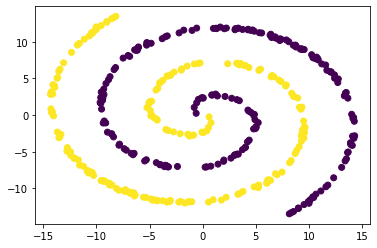

In [25]:
N = 200
D_H = 25

X, Y = twospirals(n_points=N, noise=0.1)
plt.scatter(X[:,0], X[:,1], c=Y+1)

X_test0, X_test1 = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 50),
                               np.linspace(X[:,1].min(), X[:,1].max(), 50))
X_test = np.vstack((X_test0.ravel(), X_test1.ravel())).T

In [7]:
args = {'num_warmup': 25, 'num_samples':25, 'num_chains': 1}
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y, D_H)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   w1[0,0]      0.86      0.01      0.86      0.85      0.88      2.43      3.10
   w1[0,1]      0.64      0.01      0.64      0.64      0.66      2.42      3.16
   w1[0,2]      1.34      0.00      1.34      1.33      1.34      2.40      3.32
   w1[0,3]      0.14      0.00      0.14      0.14      0.15      2.48      2.87
   w1[0,4]      0.50      0.00      0.50      0.50      0.50      2.41      3.29
   w1[0,5]      0.46      0.00      0.46      0.46      0.46      2.44      3.24
   w1[0,6]      1.85      0.00      1.85      1.84      1.85      2.41      3.25
   w1[0,7]      1.18      0.00      1.18      1.18      1.19      2.40      3.40
   w1[0,8]      1.22      0.00      1.22      1.21      1.22      2.42      3.27
   w1[0,9]      0.46      0.00      0.46      0.45      0.46      2.40      3.29
  w1[0,10]      1.54      0.00      1.54      1.54      1.54      2.75      2.57
  w1[0,11]     -0.67      0

In [11]:
# predict Y_test at inputs X_test
vmap_args = (samples, random.split(rng_key_predict, args['num_samples'] * args['num_chains']))
predictions_list = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H))(*vmap_args)


In [21]:
X_test.shape

(2500, 2)

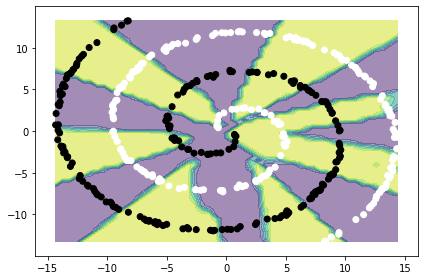

In [23]:
# make plots
fig, ax = plt.subplots(1, 1)

ax.contourf(X_test[:,0].reshape(50,50), X_test[:,1].reshape(50,50), 
            np.mean(predictions_list[...,0],0).reshape(50,50), alpha=0.5)
#plt.colorbar()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.binary)

#plt.savefig('bnn_plot.pdf')
plt.tight_layout()
plt.show()

In [ ]:


    # compute mean prediction and confidence interval around median
    mean_prediction = np.mean(predictions, axis=0)
    print(mean_prediction)
    print(mean_prediction.shape, predictions.shape)
    percentiles = onp.percentile(predictions, [5.0, 95.0], axis=0)

    # make plots
    fig, ax = plt.subplots(1, 1)

    ax.contourf(X_test0, X_test1, mean_prediction.reshape(50,50), alpha=0.5)
    #plt.colorbar()
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.binary)

    #plt.savefig('bnn_plot.pdf')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    assert numpyro.__version__.startswith('0.2.3')
    parser = argparse.ArgumentParser(description="Bayesian neural network example")
    parser.add_argument("-n", "--num-samples", nargs="?", default=2000, type=int)
    parser.add_argument("--num-warmup", nargs='?', default=1000, type=int)
    parser.add_argument("--num-chains", nargs='?', default=1, type=int)
    parser.add_argument("--num-data", nargs='?', default=100, type=int)
    parser.add_argument("--num-hidden", nargs='?', default=5, type=int)
    parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')
    args = parser.parse_args()

    numpyro.set_platform(args.device)
    numpyro.set_host_device_count(args.num_chains)

    main(args)
